In [345]:
import numpy as np    # linear algebra
import urllib         # load data from the web
import scipy.optimize # optimization routines
import random         # random number generation
import matplotlib
import pandas as pd

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Instructions
You will need the following files:
Amazon Gift Card data : https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz 
The above is a TSV formatted dataset, including reviews from one of the smaller Amazon categories. 
Data can be read using the Python csv.reader library.

In [346]:
# load the data
import gzip
path = 'amazon_reviews_us_Gift_Card_v1_00.tsv.gz'
f = gzip.open(path, 'rt', encoding="utf8")

In [347]:
dataset = []
# Read the header:
header = f.readline().strip().split('\t')
for line in f:
    # Separate by tabs
    line = line.split('\t')
    # Convert to key-value pairs
    d = dict(zip(header, line))
    # Convert strings to integers for some fields:
    d['star_rating'] = int(d['star_rating'])
    d['helpful_votes'] = int(d['helpful_votes'])
    d['total_votes'] = int(d['total_votes'])
    dataset.append(d)

### Regression - Week 1
First, let’s see how ratings can be predicted as a function of 
(a) whether a review is a ‘verified purchase’, and
(b) the length of the review (in characters)

#### 1. What is the distribution of ratings in the dataset? That is, how many 1-star, 2-star, 3-star (etc.) reviews
are there? You may write out the values or include a simple plot (1 mark).

In [348]:
df = pd.DataFrame(dataset)
df['verified_purchase'] = df['verified_purchase'].apply(lambda x: 1 if x == 'Y' else 0) # change to int

1      4793
2      1569
3      3156
4      9859
5    129709
Name: star_rating, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


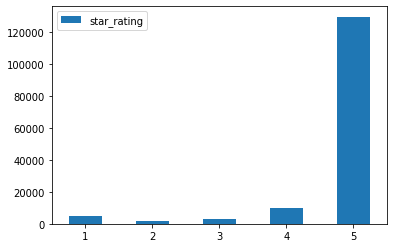

In [349]:
dist = df['star_rating'].value_counts().sort_index()
print(dist);
print(pd.DataFrame(dist).plot.bar(rot=0));

#### 2. (CSE158 only) Repeat the above question, but generate the distribution (a) only for reviews that are
‘verified,’ and (b) only for reviews that are not verified. Write out the values or generate a plot to show
the difference between these distributions (1 mark).

In [350]:
df.columns

Index(['customer_id', 'helpful_votes', 'marketplace', 'product_category',
       'product_id', 'product_parent', 'product_title', 'review_body',
       'review_date', 'review_headline', 'review_id', 'star_rating',
       'total_votes', 'verified_purchase', 'vine'],
      dtype='object')

1      4000
2      1344
3      2784
4      8940
5    118974
Name: star_rating, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


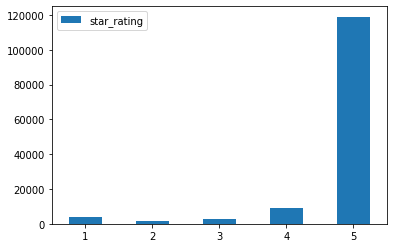

In [351]:
dist_verified = df[df['verified_purchase'] == 1]['star_rating'].value_counts().sort_index()
print(dist_verified);
print(pd.DataFrame(dist_verified).plot.bar(rot=0));

1      793
2      225
3      372
4      919
5    10735
Name: star_rating, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


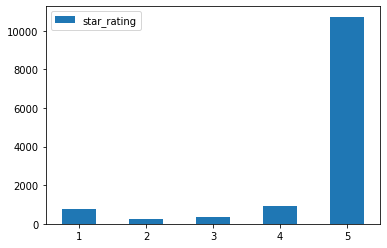

In [398]:
dist_verified = df[df['verified_purchase'] == 0]['star_rating'].value_counts().sort_index()
print(dist_verified);
print(pd.DataFrame(dist_verified).plot.bar(rot=0));

#### 3. Train a simple predictor to predict the star rating using two features:
<img src="fig1.png" style="height:50px"> 

Report the values of θ0, θ1, and θ2. Briefly describe your interpretation of these values, i.e., what do θ0,
θ1, and θ2 represent? Explain these in terms of the features and labels, e.g. if the coefficient of ‘review
length’ is negative, what would that say about positive versus negative reviews (1 mark)?

* Our feature matrix, X, will be contain the 2 columns of the df with values 'review is verified' and 'review length'
    * review length needs to be added to the df
* θ0 is the y- intercept of the regression line and θ1 & θ2 are slopes coefficients for 'review is verified' and 'review length' respectively. 

In [352]:
df['review_length'] = [len(x) for x in df['review_body']] 
# review header is included in the length calculation

In [353]:
X_1 = df[['verified_purchase', 'review_length']]
y_1 = df['star_rating']

In [354]:
from sklearn.linear_model import LinearRegression
model_1 = LinearRegression()
model_1.fit(X_1, y_1);

In [355]:
# regression coefficients
model_1.coef_

array([ 0.05041483, -0.0012466 ])

Our linear regression model calcualted θ1 = 0.05041483 (representing the coefficient for 'review is verified') and our θ2 = -0.0012466 (representing the coefficient for 'review length'). This tells us for every additional increase in star rating, the θ1 ('review is verified') increases by 0.05041483 and the θ2 ('review length') decreases by -0.0012466 .

In [356]:
model_1.intercept_

4.844618169673417

Our linear regression model calcualted θ0 = 4.844618169673417 (representing the intercept of our regression line. This tells us that if the slope, or θ1 and θ2 are 0, the star rating will still be 4.844618169673417. 

#### 4. Train another predictor that only uses one feature:
    <img src="fig2.png" style="height:50px"> 

Report the values of θ0 and θ1. Note that coefficient you found here might be quite different (i.e., much
larger or smaller) than the one from Question 3, even though these coefficients refer to the same feature.
Provide an explanation as to why these coefficients might vary so significantly (1 mark).

In [357]:
X_2 = df[['verified_purchase']]
y_2 = df['star_rating']

In [358]:
model_2 = LinearRegression()
model_2.fit(X_2, y_2);

In [359]:
model_2.coef_

array([0.16852426])

Our linear regression model calcualted θ1 = 0.16852426 (representing the coefficient for 'review is verified'). This tells us for every additional increase in star rating, the θ1 ('review is verified') increases by 0.16852426. Although this coefficient is the same as the one from question 3, its value is quite different. 

Linear Regression relys on a Conditionally Indepnedence Assumption:
if you know y, then knowing x1 provides no additional information about x2

The problem with usign linear regression (Naive Bayes) for a classification is: we can only decompose the model into the contribution of individual features if the features are independent or conditionally independent! 

This is because in simple regression (non multipul regression) the beta coefficient is propotional to the correlation between y and x. However, in multiple regression, the betas are proportional to the partial correlation. This partial correlation is the correlation between y and the considered x (controlled for the other regressors).
 
In other words, we have to make sure the columns are independent or conditionally independent if we want to use regression, and this get complicated the more features we use. 

This means we cant just do 'counting' and stick the classifications together into one big feature vector, then we would be 'double counting' the features' affect. How do we fix this? --> Logistic Regression.

In [360]:
model_2.intercept_

4.577583563324113

#### 5. Split the data into two fractions – the first 90% for training, and the remaining 10% testing (based on
the order they appear in the file). Train the same model as in Question 4 on the training set only. What
is the model’s MSE on the training and on the test set (1 mark)?

In [361]:
X_3 = df[['verified_purchase']]
y_3 = df['star_rating'].values

N = len(X_3)
n_percent = int(np.around(N*.9))
X_train = X_3[:n_percent]
X_test = X_3[n_percent:]
y_train = y_3[:n_percent]
y_test = y_3[n_percent:]

In [362]:
model_3 = LinearRegression()
model_3.fit(X_train, y_train)

predictionsTrain = model_3.predict(X_train)
predictionsTest = model_3.predict(X_test)

In [363]:
def mse(Y_pred, Y_true):
    return np.square(np.subtract(Y_true,Y_pred)).mean() 

In [364]:
# MSE for the training set:
mse(predictionsTrain, y_train)

0.6557415620280949

In [365]:
# MSE for the testing set:
mse(predictionsTest, y_test)

0.9713823241629701

It is important to note that we can still get a R^2 of 1 (MSE of 0) if we throw in enough random features! That is why we must use data that wasnt used on the model (test data) to get a more accurate representation of the R^2. 

#### 6. (CSE158 only) Using the test set from Question 5, report the Mean Absolute Error (MAE) and R2
coefficient for your predictor (on the test set) (1 mark).

In [366]:
def mae(Y_pred, Y_true):
    """ Mean Absolute Error """
    return np.mean(np.abs(np.subtract(Y_true, Y_pred)))

In [367]:
# Mean Absolute Error:
mae(predictionsTest, y_test)

0.6228362918842943

The Mean Absolute Error (MAE) is proportional to the varience of the data. This means than an 'acceptable' number for MSE depends on the varience. Therefore, it is helpful to look at the R^2 value.
* If R^2 = 0, the model is a trivial predictor
* If R^2 = 1, the model is a perfect predictor

In [368]:
from sklearn.metrics import r2_score
# R^2 value:
r2_score(y_test, predictionsTest)

-0.049088114308448505

### Classification - Week 2

In this question we’ll alter the prediction from our regression task, so that we are now classifying whether a
review is verified. Continue using the 90%/10% training and test sets you constructed previously, i.e., train on
the training set and report the error/accuracy on the testing set.

#### 8. First, let’s train a predictor that estimates whether a review is verified using the rating and the length:
 <img src="fig3.png" style="height:50px"> 

Train a logistic regressor to make the above prediction (you may use a logistic regression library with de-
fault parameters, e.g. linear model.LogisticRegression() from sklearn). 

In [369]:
X_4 = df[['star_rating', 'review_length']]
y_4 = df['verified_purchase']

N = len(X_4)
n_percent = int(np.around(N*.9))
X_train = X_4[:n_percent]
X_test = X_4[n_percent:]
y_train = y_4[:n_percent]
y_test = y_4[n_percent:]

In [370]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(C=1.0)
mod.fit(X_train, y_train);

Report the classification accuracy of this predictor. 

In [371]:
# Calculate Predictions
train_pred = mod.predict(X_train)
test_pred = mod.predict(X_test)

In [372]:
# Classification accuracy on training set:
train_accuracy = np.sum(y_train == train_pred) / len(train_pred)
train_accuracy

0.9516161488183519

In [373]:
# Classification accuracy on testing set:
test_accuracy = np.sum(y_test == test_pred) / len(test_pred)
test_accuracy

0.5589241397813401

Report also the proportion of labels that are positive (i.e., the proportion of reviews
that are verified) and the proportion of predictions that are positive (1 mark).

In [374]:
# Proportion of positive labels for training set (actual): 
np.sum(y_train) / len(y_train)

0.9518248283983097

In [375]:
# Proportion of positive labels for training set (prediction):
np.sum(train_pred) / len(train_pred)

0.9996571692614978

What does this mean? This tells us that the proportion of positive labels in our training set is high, but our predictions are almost 100% positive labels. Since our training set is ~91% positive labels, our predictions would be incorrect ~10% of the time. This is a decent predictor for the training set but, we do not know for sure if our training set is a good representation of the actual population.

In [376]:
# Proportion of positive labels for testing set (actual):
np.sum(y_test) / len(y_test)

0.5586558454624724

In [377]:
# Proportion of positive labels for testing set (prediction):
np.sum(test_pred) / len(test_pred)

0.9990609698839628

What does this mean? This tells us that the proportion of positive labels in our testing set is high, but our predictions are almost 100% positive labels. We also know, looking at the proportion of positive labels in our testing set, that the data was split well. However, since our training set is ~91% positive labels, our predictions would be incorrect ~10% of the time. This is a decent predictor for the testing set but, we do not know for sure if our testing set is a good representation of the actual population.

#### 9. Considering same prediction problem as above, can you come up with a more accurate predictor (e.g. using
features from the text, timestamp, etc.)? Write down the feature vector you design, and report its
train/test accuracy (1 mark).

Lets try to find another predictor that estimates whether a review is verified using other features. Lets take a closer look at the dataset:

In [378]:
features = df.loc[:, df.columns != 'verified_purchase']
features.head(3)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes,vine,review_length
0,24371595,0,US,Gift Card,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Great birthday gift for a young adult.,2015-08-31\n,Five Stars,R27ZP1F1CD0C3Y,5,0,N,38
1,42489718,0,US,Gift Card,B004LLIKVU,473048287,Amazon.com eGift Cards,It's an Amazon gift card and with over 9823983...,2015-08-31\n,Gift card for the greatest selection of items ...,RJ7RSBCHUDNNE,5,0,N,101
2,861463,0,US,Gift Card,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Good,2015-08-31\n,Five Stars,R1HVYBSKLQJI5S,5,0,N,4


Then I check out the distributions of some of the columns I think will make useful predictors

In [379]:
features['marketplace'].value_counts()

US    149086
Name: marketplace, dtype: int64

In [380]:
features['product_category'].value_counts()

Gift Card    149086
Name: product_category, dtype: int64

In [381]:
features['star_rating'].value_counts()

5    129709
4      9859
1      4793
3      3156
2      1569
Name: star_rating, dtype: int64

In [382]:
features['vine'].value_counts()

N    149086
Name: vine, dtype: int64

What has this told me? Features like marketplace, product category, and vine only actually have one value, so they are not very useful features.

If I wanted to use the 'review_date' as a feature, I need to convert it to a more useful for, in this case:

In [383]:
# feature engineering

In [384]:
df['is_helpful'] = df['helpful_votes'] > 0

### Final feature vector design: ['star_rating', 'review_length', 'is_helpful']

In [385]:
X_final = df[['star_rating', 'review_length', 'is_helpful']]
y_final = df['verified_purchase']

N = len(X_final)
n_percent = int(np.around(N*.9))
X_train = X_final[:n_percent]
X_test = X_final[n_percent:]
y_train = y_final[:n_percent]
y_test = y_final[n_percent:]

In [386]:
mod_2 = LogisticRegression(C=1.0)
mod_2.fit(X_train, y_train);

In [387]:
# Calculate Predictions
train_pred = mod_2.predict(X_train)
test_pred = mod_2.predict(X_test)

In [388]:
# Classification accuracy on training set:
train_accuracy_final = np.sum(y_train == train_pred) / len(train_pred)
train_accuracy_final

0.9516012431340691

In [389]:
train_accuracy_final > train_accuracy

False

In [390]:
# Classification accuracy on testing set:
test_accuracy_final = np.sum(y_test == test_pred) / len(test_pred)
test_accuracy_final

0.559125360520491

In [391]:
print(test_accuracy_final)
print(test_accuracy)

0.559125360520491
0.5589241397813401


In [392]:
test_accuracy_final > test_accuracy

True

Woohoo! Testing accuracy has improved!

### Final Thoughts

Just out of curiousity, lets check distribution of labels:

In [393]:
# Proportion of positive labels for training set (actual):
np.sum(y_train) / len(y_train)

0.9518248283983097

In [394]:
# Proportion of positive labels for training set (prediction):
np.sum(train_pred) / len(train_pred)

0.9996571692614978

In [395]:
# Proportion of positive labels for testing set (actual):
np.sum(y_test) / len(y_test)

0.5586558454624724

In [396]:
# Proportion of positive labels for testing set (prediction):
np.sum(test_pred) / len(test_pred)

0.9991280434636797

What does this tell us?
These proportions are similiar to the proportions on the previous model we designed. This is expected since the accuracy did improve, but not by that much. This also leads me to suspect that the predictor will not perform this well on unseen data, since the classes (or values of 'verified_purchase') in the training data is almost entirely positive, unless this is an accurate represent the actual population (this does not seem to be the case since the actual labels in the testing data are only ~55% positive). How can we improve this? Maybe try shuffling the data instead of just picking the first 90% for training. Maybe train on less data (e.g. increasing testing data to 20%). Or maybe try running the LogisticRegression() model with the classes 'balanced'. Or better yet, if it was possible, get more data!